In [1]:
# Import libraries
import pandas as pd
import numpy as np

import seaborn as sns
from tabulate import tabulate
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error, plot_roc_curve, confusion_matrix, f1_score, precision_score, recall_score, accuracy_score, roc_auc_score, make_scorer

import joblib
from scipy.stats import ttest_ind

In [2]:
# Load data
df = pd.read_csv('data/Salaries.csv')

In [3]:
# Print first 5 rows
df.head()

,rank,discipline,yrs.since.phd,yrs.service,sex,salary
0,Prof,B,19,18,Male,139750
1,Prof,B,20,16,Male,173200
2,AsstProf,B,4,3,Male,79750
3,Prof,B,45,39,Male,115000
4,Prof,B,40,41,Male,141500


In [4]:
# Rename columns
df.rename(columns={'yrs.since.phd': 'yrs_since_phd', 'yrs.service': 'yrs_service'}, inplace=True)

In [5]:
# Check NAs and datatypes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 397 entries, 0 to 396
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   rank           397 non-null    object
 1   discipline     397 non-null    object
 2   yrs_since_phd  397 non-null    int64 
 3   yrs_service    397 non-null    int64 
 4   sex            397 non-null    object
 5   salary         397 non-null    int64 
dtypes: int64(3), object(3)
memory usage: 18.7+ KB


In [6]:
# Create numerical and categorical variable lists
num_vars = ['yrs_since_phd', 'yrs_service', 'salary']
cat_vars = ['rank', 'discipline', 'sex']

In [7]:
# Look at numerical value stats
df.describe()

,yrs_since_phd,yrs_service,salary
count,397.000000,397.000000,397.000000
mean,22.314861,17.614610,113706.458438
std,12.887003,13.006024,30289.038695
min,1.000000,0.000000,57800.000000
25%,12.000000,7.000000,91000.000000
50%,21.000000,16.000000,107300.000000
75%,32.000000,27.000000,134185.000000
max,56.000000,60.000000,231545.000000


# Analysis

In [9]:
# What percentage of records are Assistant Professors with less than 5 years of experience?
print(round(df[(df['rank'] == 'AsstProf') & (df['yrs_service'] < 5)].shape[0]/df.shape[0] * 100, 2))

15.87


In [10]:
# Is there a statistically significant difference between female and male salaries?
salaries_male = df.loc[df['sex'] == 'Male', 'salary']
salaries_female = df.loc[df['sex'] == 'Female', 'salary']

stat, p = ttest_ind(salaries_male, salaries_female)

print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
    print('NOT statistically significant.')
else:
    print('Statistically significant.')

stat=2.782, p=0.006
Statistically significant.


In [13]:
# Mean salaries 
print('Male Avg. Salary: {}'.format(round(salaries_male.mean()), 0))
print('Female Avg. Salary: {}'.format(round(salaries_female.mean()), 0))

Male Avg. Salary: 115090
Female Avg. Salary: 101002


<AxesSubplot:xlabel='rank', ylabel='salary'>

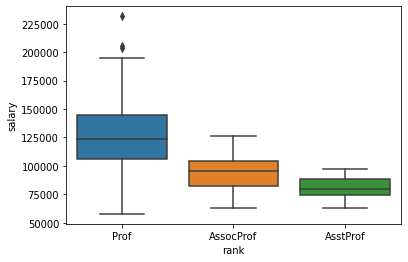

In [15]:
# What is the distribution of salary by rank and discipline?
sns.boxplot(data=df, x = 'rank', y = 'salary', order=['Prof', 'AssocProf', 'AsstProf'])

<AxesSubplot:xlabel='discipline', ylabel='salary'>

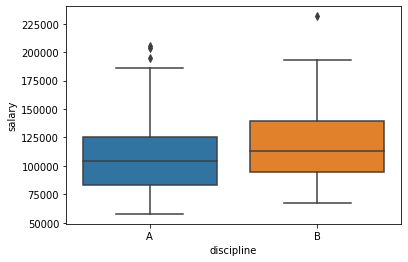

In [16]:
sns.boxplot(data=df, x = 'discipline', y = 'salary', order=['A', 'B'])

In [290]:
# How would you recode discipline as a 0/1 binary indicator?
df['discipline']

0      B
1      B
2      B
3      B
4      B
      ..
392    A
393    A
394    A
395    A
396    A
Name: discipline, Length: 397, dtype: object

In [603]:
df['discipline'].apply(lambda x: 1 if x == 'A' else 0)

0      0
1      0
2      0
3      0
4      0
      ..
392    1
393    1
394    1
395    1
396    1
Name: discipline, Length: 397, dtype: int64

In [291]:
enc = OneHotEncoder()
enc.fit(df[['discipline']])
pd.DataFrame(data=enc.transform(df[['discipline']]).toarray(), columns=enc.categories_)

,A,B
0,0.0,1.0
1,0.0,1.0
2,0.0,1.0
3,0.0,1.0
4,0.0,1.0
...,...,...
392,1.0,0.0
393,1.0,0.0
394,1.0,0.0
395,1.0,0.0


# Model Building

In [36]:
class ModelContainer:
    '''This class captures the entire ML pipeline for both regression and classification models.'''
    
    def __init__(self, df, model_type='regression'):
        # Define variables
        self.df = df.copy()
        self.model_type = model_type
        self.num_vars = ['yrs_since_phd', 'yrs_service', 'salary']
        self.cat_vars = ['rank', 'discipline', 'sex']
        self.target = 'salary'
        self.features = []
        self.parameters = {'model__max_depth': [2, 4, 6, 8],
                           'model__min_samples_split': [5, 10, 15, 20, 30],
                           'model__random_state': [42]
                           }
    
        # Create features list
        self.features = self.num_vars + self.cat_vars
        self.features.remove(self.target)
        
        # Create target variable
        if self.model_type == 'classification':
            self.df[self.target] = self.df[self.target].apply(lambda x: 1 if x >= np.median(self.df[self.target]) else 0)
        
        # Print features and target list
        print('Features: {}'.format(self.features))
        print('Target: {}'.format(self.target))
    
    def split_data(self):
        # Split data
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.df[self.features], self.df[self.target], test_size = 0.2, random_state=42)

        # Print dataframe shapes for train and test datasets
        print('Dataset Shapes ->')
        print('X_train: {}'.format(self.X_train.shape))
        print('y_train: {}'.format(self.X_test.shape))
        print('X_test: {}'.format(self.y_train.shape))
        print('y_test: {}'.format(self.y_test.shape))
    
    def create_ohe(self):
        # OneHotEncoder for categorical variables
        self.preprocessor = ColumnTransformer([
            ('ohe', OneHotEncoder(), self.cat_vars)
        ],
        remainder='passthrough')
        
        # Display original data
        print('Training Dataset - Unprocessed')
        print(tabulate(self.X_train.head(), headers='keys', tablefmt='psql'))
        
        # Display transformed data
        preprocessed_data = pd.DataFrame(data=self.preprocessor.fit_transform(self.X_train), columns=self.preprocessor.get_feature_names())
        print('Training Dataset - Processed')
        print(tabulate(preprocessed_data.head(), headers='keys', tablefmt='psql'))

    def create_ml_pipeline(self):
        # Define classification or regression model
        if self.model_type == 'regression':
            model = RandomForestRegressor()
        else:
            model = RandomForestClassifier()
        
        # Create ML pipeline
        self.pipeline = Pipeline([
            ('preprocessor', self.preprocessor),
            ('model', model)
        ])
    
    def train_model(self):
        # Run grid search on ML pipeline
        if self.model_type == 'regression':
            self.model = GridSearchCV(self.pipeline, param_grid=self.parameters, cv=3)
            self.model.fit(self.X_train, self.y_train)
        else:
            scorer = make_scorer(f1_score)
            self.model = GridSearchCV(self.pipeline, param_grid=self.parameters, scoring=scorer, cv=3)
            self.model.fit(self.X_train, self.y_train)
        
        print('Model training complete!')
            
        
    def plot_feature_importance(self):
        # Show feature importances
        feature_importance = pd.Series(data = self.model.best_estimator_['model'].feature_importances_, index=self.preprocessor.get_feature_names()).sort_values()
        feature_importance.plot(kind='barh')
        plt.title('Feature Importance')
        plt.show()
    
    def plot_model_performance(self):
        '''Plot model performance based on model type i.e. Classification or Regression'''
        
        # For regression model
        if self.model_type == 'regression':
            preds = self.model.predict(self.X_test)
            plt.scatter(preds, self.y_test)
            plt.xlabel('Predicted Salary')
            plt.ylabel('Actual Salary')
            
            model_corr = round(np.corrcoef(preds, self.y_test)[0][1], 2)
            model_rmse = round(np.sqrt(mean_squared_error(self.y_test, preds)),2)
            plt.title('Correlation: {}\nRoot Mean Squared Error: {}'.format(model_corr, model_rmse))
            plt.show()
        
        # For classification model
        else:
            preds = self.model.predict(self.X_test)
#             print(confusion_matrix(self.y_test, preds))
#             tn, fp, fn, tp = confusion_matrix(self.y_test, preds).ravel()
#             print(tp, tn, fp, fn)
            print('Accuracy: {}\nPrecision: {}\nRecall: {}\nAUC Score: {}'.format(round(accuracy_score(self.y_test, preds),2), 
                                                                                  round(precision_score(self.y_test, preds),2), 
                                                                                  round(recall_score(self.y_test, preds),2), 
                                                                                  round(roc_auc_score(self.y_test, preds)))
            plot_roc_curve(self.model, self.X_test, self.y_test)  
            plt.show() 
    
    def save_model(self):
        '''Save model to folder'''
        if self.model_type == 'regression':
            model_path = 'model/rgr.pkl'
        else:
            model_path = 'model/clf.pkl'
        
        joblib.dump(self.model, model_path)
        print('Model saved!')


## Regression Model

Features: ['yrs_since_phd', 'yrs_service', 'rank', 'discipline', 'sex']
Target: salary
Dataset Shapes ->
X_train: (317, 5)
y_train: (80, 5)
X_test: (317,)
y_test: (80,)
Training Dataset - Unprocessed
+-----+-----------------+---------------+-----------+--------------+--------+
|     |   yrs_since_phd |   yrs_service | rank      | discipline   | sex    |
|-----+-----------------+---------------+-----------+--------------+--------|
| 262 |              31 |            26 | Prof      | A            | Male   |
| 113 |              37 |            37 | Prof      | A            | Male   |
| 176 |              10 |             7 | AssocProf | B            | Male   |
|  63 |              11 |            11 | AssocProf | B            | Female |
| 245 |              17 |            11 | Prof      | A            | Female |
+-----+-----------------+---------------+-----------+--------------+--------+
Training Dataset - Processed
+----+---------------------+--------------------+----------------+---

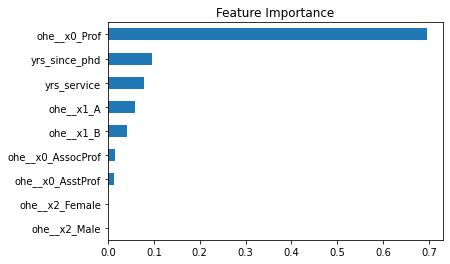

Model saved!


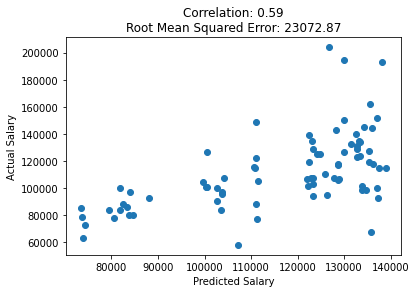

In [38]:
# Define regression model
rgr = ModelContainer(df, model_type = 'regression')

# Split data into training and test sets
rgr.split_data()

# Create preprocess for one-hot encoding
rgr.create_ohe()

# Create ML pipeline
rgr.create_ml_pipeline()

# Show ML pipeline structure
print('ML Pipeline: {}'.format(rgr.pipeline))

# Train model
rgr.train_model()

# Print best hyperparameters
print('Best Parameters: {}'.format(rgr.model.best_params_))

# Plot feature importance
rgr.plot_feature_importance()

# Plot model performance
rgr.plot_model_performance()

# Save model
rgr.save_model()

# Classification Model

Features: ['yrs_since_phd', 'yrs_service', 'rank', 'discipline', 'sex']
Target: salary
Dataset Shapes ->
X_train: (317, 5)
y_train: (80, 5)
X_test: (317,)
y_test: (80,)
Training Dataset - Unprocessed
+-----+-----------------+---------------+-----------+--------------+--------+
|     |   yrs_since_phd |   yrs_service | rank      | discipline   | sex    |
|-----+-----------------+---------------+-----------+--------------+--------|
| 262 |              31 |            26 | Prof      | A            | Male   |
| 113 |              37 |            37 | Prof      | A            | Male   |
| 176 |              10 |             7 | AssocProf | B            | Male   |
|  63 |              11 |            11 | AssocProf | B            | Female |
| 245 |              17 |            11 | Prof      | A            | Female |
+-----+-----------------+---------------+-----------+--------------+--------+
Training Dataset - Processed
+----+---------------------+--------------------+----------------+---

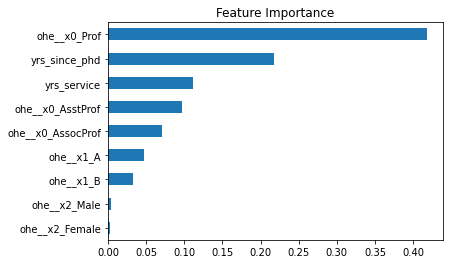

[1 1 0 0 1 0 1 0 0 1 1 1 1 1 1 0 1 0 0 0 1 1 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1
 1 1 0 1 1 0 1 1 1 1 1 1 1 1 0 1 0 1 0 1 1 1 0 1 0 1 0 1 1 0 1 0 0 0 1 1 1
 0 1 1 0 1 1]
[[25 16]
 [ 1 38]]
38 25 16 1
Accuracy: 0.7875
Precision: 0.7037037037037037
Recall: 0.9743589743589743
AUC Score: 0.7920575359599751


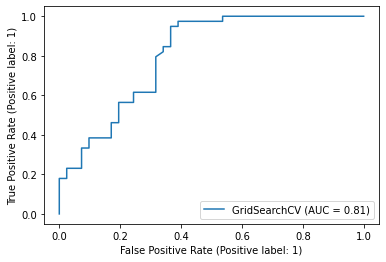

Model saved!


In [42]:
# Define regression model
clf = ModelContainer(df, model_type = 'classification')

# Split data into training and test sets
clf.split_data()

# Create preprocess for one-hot encoding
clf.create_ohe()

# Create ML pipeline
clf.create_ml_pipeline()

# Show ML pipeline structure
print('ML Pipeline: {}'.format(clf.pipeline))

# Train model
clf.train_model()

# Print best hyperparameters
print('Best Parameters: {}'.format(rgr.model.best_params_))

# Plot feature importance
clf.plot_feature_importance()

# Plot model performance
clf.plot_model_performance()

# Save model
clf.save_model()